# Libraries

In [70]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from tqdm import tqdm
cudnn.benchmark = True
plt.ion()   # interactive mode

In [71]:
notebook_path = Path().cwd()
project_path = notebook_path.parent
repo_path = project_path.parent
print(f'The current directory is {notebook_path}')

The current directory is /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Deep_Learning/notebooks


Prepare data
- This includes:
    - Preprocessing the data
    - Define datasets dictiornaries with paths, classes, etc.
    - Define the data loaders

In [72]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#directory with images
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
#define dictionary containing the train and validation image folder objects
#it contains the image paths, as well as the class and other atirbutes.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#define dictionary containing the train and validation data loaders
#This is taking the image folder object, the batch size, and shuffling the images.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
#define dictionary with the train and validation dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#get classes names
class_names = image_datasets['train'].classes
#define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We look at some images to see if they are fine

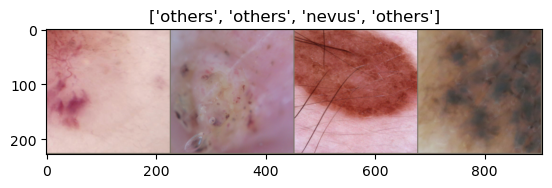

In [73]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We define the trainning function

In [74]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #training starting time
    since = time.time()
    #deep copy of the model's state dicitonary (the weights)
    best_model_wts = copy.deepcopy(model.state_dict())
    #save accuracy variable
    best_acc = 0.0

    for epoch in range(num_epochs): #go thorugh all epochs
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        #After finishing training with one epoch, the validation set is used to check performance.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            #reset loss and accuracy variables
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                #send inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # FORWARD step
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #get model outputs
                    outputs = model(inputs)
                    #????
                    _, preds = torch.max(outputs, 1)
                    #compute loss
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # store statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                #change learning rate according to the scheduler
                scheduler.step()
            #get epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #print the phase loss and accuracy
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if the epoch validation accuracy is the highest
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
    
    #after all epochs, print the total training time, and the best validation accuracy
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [75]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

With everything defined we can now load the model

In [76]:
#load pretrained model
model = models.resnet18(weights='DEFAULT')
#check model architecture
#torchsummary.summary(model, (3, 224, 224))
#check number of features extracted before the last FC layer
num_features = model.fc.in_features
#change number of outputs from FCL to 2
model.fc = nn.Linear(num_features, 2)
#send model to device
model = model.to(device)
#define loss function
criterion = nn.CrossEntropyLoss()
#define optimizer as SGD
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#define scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [77]:
model = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|██████████| 3799/3799 [14:08<00:00,  4.48it/s]


train Loss: 0.6734 Acc: 0.6893


100%|██████████| 949/949 [01:20<00:00, 11.85it/s]


val Loss: 0.4340 Acc: 0.8082
Epoch 1/24
----------


  7%|▋         | 277/3799 [01:02<13:09,  4.46it/s]


KeyboardInterrupt: 